# Loading Datasets

In [2]:
import shap
import numpy  as np
import pandas as pd
import plotly.express as px
#import matplotlib.pyplot as plt
import time

from sklearn.impute   import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import accuracy_score, auc, roc_curve, precision_recall_curve, roc_auc_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost  import XGBClassifier

#plt.style.use('ggplot')

In [3]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows',300) # Set display rows to 300 
pd.set_option('display.max_columns',300) # Set Display columns to 300

In [4]:
# Loading datasets
df = pd.read_excel("icu_prediction.xlsx")

<br><br><br><br>

# Data Exploration

In [5]:
df.head(8)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

* There are 385 patients with 1 row of measurment for 5 different time intervals. <br>
Making the full dataset 1925 rows.
<br><br><br><br>

In [6]:
df["ICU"].value_counts()

0    1410
1     515
Name: ICU, dtype: int64

* There is a class imbalance of 73.25% favoring class 0. <br>
This will be the baseline accuracy for which our model has to compete with.
<br><br><br><br>

In [7]:
# Find out if any patient was admitted to the ICU at any of the time-intervals
(df.groupby('PATIENT_VISIT_IDENTIFIER').sum()['ICU'] > 0).value_counts()

True     195
False    190
Name: ICU, dtype: int64

* Out of 385 patients, 195 patients (50.65%) were at some point admitted to the ICU.


<br><br><br><br>

Text(0.5, 1.0, 'Age Distribution')

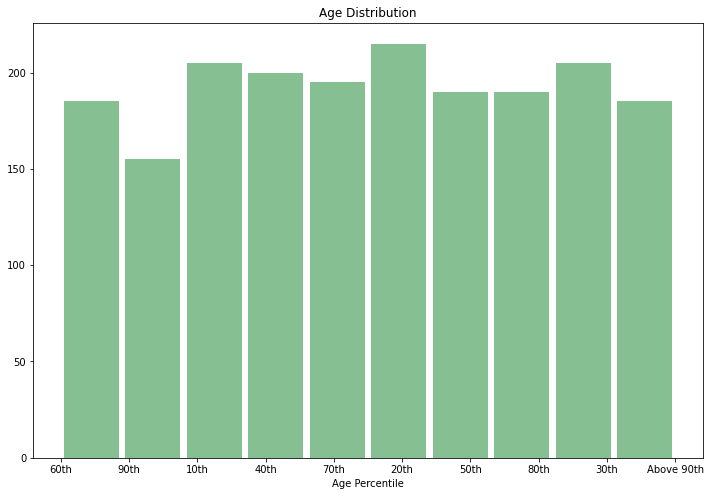

In [8]:
import pylab as pl
ax = df["AGE_PERCENTIL"].hist(bins=10, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax.set_xlabel("Age Percentile")
pl.title('Age Distribution')

In [9]:
# Checking the proportions of Nulls
missing_props = df.isna().sum() / len(df)
missing_props[missing_props > 0].sort_values(ascending=False)

P02_VENOUS_MAX                      0.573506
PH_ARTERIAL_MIN                     0.573506
PC02_VENOUS_MAX                     0.573506
PC02_VENOUS_DIFF                    0.573506
PCR_MEDIAN                          0.573506
PCR_MEAN                            0.573506
PCR_MIN                             0.573506
PCR_MAX                             0.573506
PCR_DIFF                            0.573506
PH_ARTERIAL_MEDIAN                  0.573506
PH_ARTERIAL_MEAN                    0.573506
PH_ARTERIAL_MAX                     0.573506
PC02_VENOUS_MEAN                    0.573506
PH_ARTERIAL_DIFF                    0.573506
PH_VENOUS_MEDIAN                    0.573506
PH_VENOUS_MEAN                      0.573506
PH_VENOUS_MIN                       0.573506
PH_VENOUS_MAX                       0.573506
PH_VENOUS_DIFF                      0.573506
PLATELETS_MEDIAN                    0.573506
PLATELETS_MEAN                      0.573506
PLATELETS_MIN                       0.573506
PC02_VENOU

<br>

# Preprocessing

In [10]:
""" 

# Create a dataframe that identify for every patient if any of its ICU values more than 0
ICU_admitted = (df.groupby('PATIENT_VISIT_IDENTIFIER').sum()['ICU'] > 0).reset_index()*1  #  '*1' to convert True/False to (1, 0)
# Join the two dataframe and add '_admitted' to common ICU column
df = df.join(ICU_admitted.set_index('PATIENT_VISIT_IDENTIFIER'), on = 'PATIENT_VISIT_IDENTIFIER', rsuffix='_admitted')
# Delete any record that had `ICU = 1` and create it in `df_model`
df_model = df[df.ICU == 0]
# Drop columns
df_model.drop( ['ICU', 'PATIENT_VISIT_IDENTIFIER'], axis = 1, inplace = True)


"""

" \n\n# Create a dataframe that identify for every patient if any of its ICU values more than 0\nICU_admitted = (df.groupby('PATIENT_VISIT_IDENTIFIER').sum()['ICU'] > 0).reset_index()*1  #  '*1' to convert True/False to (1, 0)\n# Join the two dataframe and add '_admitted' to common ICU column\ndf = df.join(ICU_admitted.set_index('PATIENT_VISIT_IDENTIFIER'), on = 'PATIENT_VISIT_IDENTIFIER', rsuffix='_admitted')\n# Delete any record that had `ICU = 1` and create it in `df_model`\ndf_model = df[df.ICU == 0]\n# Drop columns\ndf_model.drop( ['ICU', 'PATIENT_VISIT_IDENTIFIER'], axis = 1, inplace = True)\n\n\n"

In [11]:
# Data Preparation
df['AGE_PERCENTIL'] = df['AGE_PERCENTIL'].str.replace('Above ','').str.extract(r'(.+?)th')
df['WINDOW'] = df['WINDOW'].str.replace('ABOVE_12','12-more').str.extract(r'(.+?)-')

# Missingness as features
df['row_missingness'] = df.isnull().sum(axis=1)

# Mean imputation
mean_impute  = SimpleImputer(strategy='mean')
imputed_data = mean_impute.fit_transform(df)
imputed_data = pd.DataFrame(imputed_data, columns = df.columns)

In [12]:
imputed_data

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,row_missingness
0,0.0,1.0,60.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.528527,0.528527,0.528527,0.528527,-1.0,-0.963433,-0.963433,-0.963433,-0.963433,-1.0,-0.931121,-0.931121,-0.931121,-0.931121,-1.0,-0.310924,-0.310924,-0.310924,-0.310924,-1.0,-0.311845,-0.311845,-0.311845,-0.311845,-1.0,-0.945928,-0.945928,-0.945928,-0.945928,-1.0,-0.994424,-0.994424,-0.994424,-0.994424,-1.0,0.330359,0.330359,0.33

In [49]:
for i in imputed_data.columns:
    if type(imputed_data[i].iloc[0]) == str:
        factor = pd.factorize(imputed_data[i])
        imputed_data[i] = factor[0]
        definitions = factor[1]

In [50]:
from sklearn.model_selection import train_test_split
#Independent Vector
X = imputed_data[list(imputed_data.columns)[:-2]].values
#Dependent Vector
y = imputed_data[imputed_data.columns[-2]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.nan_to_num(X_train))
X_test = scaler.transform(np.nan_to_num(X_test))

In [52]:
rf_optimal = {
              'n_estimators': 2100,
              'max_depth': 27,
              'max_features': 0.15,
              'max_samples': 0.5363991145732665,
              'min_samples_split': 2,
              'min_samples_leaf': 4,
              'n_jobs': -1,
              'random_state': 451,
            }

In [55]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
#model = RandomForestClassifier(n_jobs=64, n_estimators=200, criterion='entropy',oob_score=True)
model = RandomForestClassifier(**rf_optimal)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc =  metrics.accuracy_score(y_test, y_pred)

In [56]:
from sklearn.metrics import roc_curve, auc
print('accuracy ' + str(acc))
#print('average auc ' +str(roc_auc["average"]))
prfs = precision_recall_fscore_support(y_test, y_pred, labels = [0,1])
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('precision:',prfs[0] )
print('recall', prfs[1])
print('fscore', prfs[2])

accuracy 0.8857142857142857
precision: [0.91034483 0.81052632]
recall [0.93617021 0.74757282]
fscore [0.92307692 0.77777778]


In [59]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 27,
 'max_features': 0.15,
 'max_leaf_nodes': None,
 'max_samples': 0.5363991145732665,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 451,
 'verbose': 0,
 'warm_start': False}

In [60]:
import joblib

# Save the hyperparameters to a file
joblib.dump(model.get_params(), "rf_params.pkl")

['rf_params.pkl']

In [63]:
import pickle

with open('rf_params.pkl', 'rb') as f:
    data = pickle.load(f)

print(type(data))
print(data)

<class 'dict'>
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 27, 'max_features': 0.15, 'max_leaf_nodes': None, 'max_samples': 0.5363991145732665, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 2100, 'n_jobs': -1, 'oob_score': False, 'random_state': 451, 'verbose': 0, 'warm_start': False}


In [29]:
from sklearn.model_selection import StratifiedKFold
from xgboost  import XGBClassifier
from sklearn.metrics import roc_auc_score

In [30]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [31]:
from sklearn.model_selection import RandomizedSearchCV
folds = 3
param_comb = 5
xgb = XGBClassifier(n_estimators=100)
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb,
                                   scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001)
random_search.fit(X, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 3/3] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.928 total time=   0.5s
[CV 2/3] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.905 total time=   0.5s
[CV 1/3] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.916 total time=   0.5s
[CV 1/3] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.925 total time=   0.7s
[CV 1/3] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.920 total time=   0.6s
[CV 2/3] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.914 total time=   0.7s
[CV 3/3] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.941 total time=   0.7s
[CV 2/3] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x163d9cdd0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=No...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='roc_auc', verbose=3)

In [32]:
xgb2 = XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=np.nan,
                                           num_parallel_tree=1, random_state=0,
                                           reg_alpha=0, reg_lambda=1,
                                           scale_pos_weight=1, subsample=1,
                                           tree_method='exact',
                                           validate_parameters=1,
                                           verbosity=None)
training_start = time.perf_counter()
xgb2.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb2.predict(X_test, output_margin=True)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 0.00
Time consumed for training: 0.529
Time consumed for prediction: 0.03672 seconds


In [33]:
# save the model in binary format
xgb2.save_model("saved_model.json")

# Neural Network

In [138]:
from sklearn.model_selection import train_test_split

df_test = imputed_data.copy()
target = 'ICU'
y = df_test.pop(target)
X = df_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [139]:
import keras
import keras_tuner as kt
import tensorflow as tf

In [140]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(Dense(128, input_shape=(231,), activation='relu'))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(10))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

In [141]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt/oracle.json


ValueError: `sampling` can only be set on an `Int` when `step=1`.

In [25]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [26]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

KeyError: <keras_tuner.engine.trial.Trial object at 0x000001D6A98B6B80>

In [ ]:
import tensorflow as tf
import numpy as np

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_dim=X_train.shape[1]),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model with a loss function and optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model using the training data
model.fit(X_train, y_train, epochs=10)

y_pred = model.predict(X_test)

# Evaluate the model using the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/10
52/52 [==============================] - 0s 686us/step - loss: 9.8531 - accuracy: 0.5134
Epoch 2/10
52/52 [==============================] - 0s 813us/step - loss: 0.9124 - accuracy: 0.7011
Epoch 3/10
52/52 [==============================] - 0s 784us/step - loss: 0.5338 - accuracy: 0.7647
Epoch 4/10
52/52 [==============================] - 0s 736us/step - loss: 0.4594 - accuracy: 0.7952
Epoch 5/10
52/52 [==============================] - 0s 1ms/step - loss: 0.4673 - accuracy: 0.8001
Epoch 6/10
52/52 [==============================] - 0s 1ms/step - loss: 0.4202 - accuracy: 0.8258
Epoch 7/10
52/52 [==============================] - 0s 824us/step - loss: 0.4179 - accuracy: 0.8215
Epoch 8/10
52/52 [==============================] - 0s 745us/step - loss: 0.4199 - accuracy: 0.8240
Epoch 9/10
52/52 [==============================] - 0s 686us/step - loss: 0.3980 - accuracy: 0.8313
Epoch 10/10
10/10 [==============================] - 0s 667us/step - loss: 0.4680 - accuracy: 0.7682
Tes